In [1]:
import re
import pandas as pd
from collections import defaultdict

# sumy
from __future__ import absolute_import
from __future__ import division, print_function, unicode_literals
 
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
from sumy.summarizers.edmundson import EdmundsonSummarizer

# NLTK stopwords
from nltk.corpus import stopwords

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Set Pandas to display all rows of dataframes
pd.set_option('display.max_rows', 500)

In [2]:
books = ["data/Rowling, J.K. - HP 1 - Harry Potter and the Sorcerer's Stone.txt",
         "data/Rowling, J.K. - HP 2 - Harry Potter and the Chamber of Secrets.txt",
         "data/Rowling, J.K. - HP 3 - Harry Potter and the Prisoner of Azkaban.txt",
         "data/Rowling, J.K. - HP 4 - Harry Potter and the Goblet of Fire.txt",
         "data/Rowling, J.K. - HP 5 - Harry Potter and the Order of the Phoenix.txt",
         "data/Rowling, J.K. - HP 6 - Harry Potter and the Half-Blood Prince.txt",
         "data/Rowling, J.K. - HP 7 - Harry Potter and the Deathly Hallows.txt"]

In [3]:
pattern = ("(C H A P T E R (?:[A-Z-][ ]){2,}[A-Z])\s+" +  # Group 1 selects the chapter number
           "([A-Z \n',.-]+)\\b(?![A-Z]+(?=\.)\\b)" + # Group 2 selects the chapter title but excludes all caps word beginning first sentence of the chapter
           "(?![a-z']|[A-Z.])" +                     # chapter title ends before lowercase letters or a period
           "(.*?)" +                                 # Group 3 selects the chapter contents
           "(?=C H A P T E R (?:[A-Z][ ]){2,}|This\s+book\s+was\s+art\s+directed\s+)")      # chapter contents ends with a new chapter or the end of book
hp = defaultdict(dict)
for book in books:
    title = book[28:-4]
    with open(book, 'r') as f:
        text = (f.read().replace('&rsquo;', "'")
                        .replace('&lsquo;', "'")
                        .replace('&rdquo;', '"')
                        .replace('&ldquo;', '"')
                        .replace('&mdash;', '—'))
    chapters = re.findall(pattern, text, re.DOTALL)
    chap = 0
    for chapter in chapters:
        chap += 1
        chap_title = chapter[1].replace('\n','')
        chap_text = chapter[2][3:]
        phrase = ' HE-WHO-MUST-NOT-BE-NAMED RETURNS'
        if phrase in chap_title:
            chap_title = chap_title.replace(phrase, '')
            chap_text = phrase[1:] + ' I' + chap_text
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
        chap_text = re.sub('\n*&bull; [0-9]+ &bull;\s*CHAPTER [A-Z-]+\s*', '', chap_text)
        chap_text = re.sub(' \n&bull; [0-9]+ &bull; \n*', '', chap_text)
#         chap_text = re.sub('\n+', '\n', chap_text)
        chap_text = re.sub('\s*'.join([word for word in chap_title.split()]), '', chap_text)
        hp[title]['Chapter ' + str(chap)] = (chap_title, chap_text)
hp = dict(hp)

### The format of the Harry Potter hp dictionary is as follows:
&nbsp;   
{book 1 title: {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 2': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 3': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 'book 2 title': {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 &nbsp;...  
}  

In [4]:
stop_words = stopwords.words('english')

In [5]:
# Convert to list
data = [hp[book][chapter][1].replace('\n', '') for book in hp for chapter in hp[book]]

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [7]:
data_words = list(sent_to_words(data))

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [12]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '~/mallet-2.0.8/bin/mallet' # update this path

In [13]:
def compute_coherence_values(dictionary, corpus, texts, stop, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        print('Calculating {}-topic model'.format(num_topics))
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [14]:
# Can take a long time to run.
start=5; stop=35; step=1;
stop += 1
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        stop=stop,
                                                        step=step)

Calculating 5-topic model
Calculating 6-topic model
Calculating 7-topic model
Calculating 8-topic model
Calculating 9-topic model
Calculating 10-topic model
Calculating 11-topic model
Calculating 12-topic model
Calculating 13-topic model
Calculating 14-topic model
Calculating 15-topic model
Calculating 16-topic model
Calculating 17-topic model
Calculating 18-topic model
Calculating 19-topic model
Calculating 20-topic model
Calculating 21-topic model
Calculating 22-topic model
Calculating 23-topic model
Calculating 24-topic model
Calculating 25-topic model
Calculating 26-topic model
Calculating 27-topic model
Calculating 28-topic model
Calculating 29-topic model
Calculating 30-topic model
Calculating 31-topic model
Calculating 32-topic model
Calculating 33-topic model
Calculating 34-topic model
Calculating 35-topic model


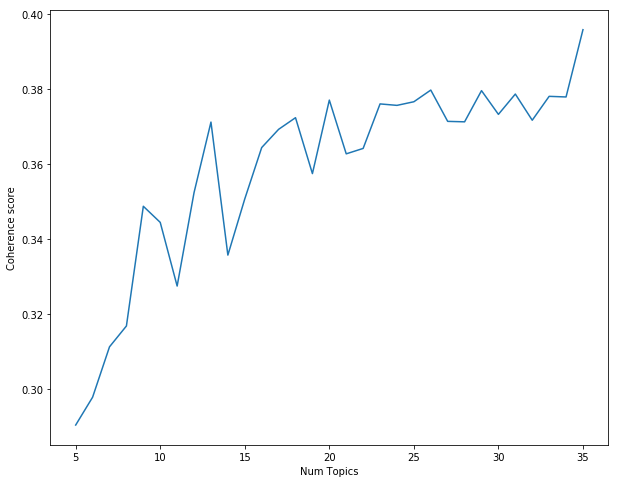

In [15]:
# Show graph
x = range(start, stop, step)
plt.figure(figsize=(10, 8))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.show()

In [16]:
# Print the coherence scores
idx = 0
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6), '  Model index', idx)
    idx += 1

Num Topics = 5  has Coherence Value of 0.290484   Model index 0
Num Topics = 6  has Coherence Value of 0.297892   Model index 1
Num Topics = 7  has Coherence Value of 0.311315   Model index 2
Num Topics = 8  has Coherence Value of 0.316868   Model index 3
Num Topics = 9  has Coherence Value of 0.348748   Model index 4
Num Topics = 10  has Coherence Value of 0.344458   Model index 5
Num Topics = 11  has Coherence Value of 0.327501   Model index 6
Num Topics = 12  has Coherence Value of 0.352394   Model index 7
Num Topics = 13  has Coherence Value of 0.371172   Model index 8
Num Topics = 14  has Coherence Value of 0.335743   Model index 9
Num Topics = 15  has Coherence Value of 0.350716   Model index 10
Num Topics = 16  has Coherence Value of 0.364386   Model index 11
Num Topics = 17  has Coherence Value of 0.369238   Model index 12
Num Topics = 18  has Coherence Value of 0.372339   Model index 13
Num Topics = 19  has Coherence Value of 0.357451   Model index 14
Num Topics = 20  has Cohe

In [17]:
# Select the model and print the topics
index = 15
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(formatted=False)

In [18]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [19]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['document_number', 'dominant_topic', 'topic_percent_contribution', 'keywords', 'text']

In [20]:
bonus_words = [text.split(', ') for text in df_dominant_topic['keywords'].tolist()]

In [21]:
len(bonus_words)

198

In [22]:
def summarize(text, sentence_count, bonus_words, language='english'):
    summarizer = EdmundsonSummarizer(Stemmer(language))
    summarizer.stop_words = get_stop_words(language)
    summarizer.bonus_words = bonus_words
    summarizer.stigma_words = ['zdfgthdvndadv']
    summarizer.null_words = stopwords.words('english')
    summary = summarizer(PlaintextParser(text, Tokenizer(language)).document, sentence_count)
    return summary

In [23]:
def print_summary(summary):
    for sentence in summary:
        print(sentence)

In [24]:
doc = 0
for book in hp:
    print(book)
    for chapter in hp[book]:
        print('{} - {}'.format(chapter, hp[book][chapter][0]))
        words = bonus_words[doc]
        # split up bigrams used in LDA model
        words = [item for sublist in [item.split('_') for item in words] for item in sublist]
        words.extend(hp[book][chapter][0].lower().split())
        print_summary(summarize(hp[book][chapter][1], 5, words))
        doc += 1
        print()
    print()

Harry Potter and the Sorcerer's Stone
Chapter 1 - THE BOY WHO LIVED
At half past eight, Mr. Dursley picked up his briefcase, pecked Mrs. Dursley on the cheek, and tried to kiss Dudley good-bye but missed, because Dudley was now having a tantrum and throwing his cereal at the walls.
When Dudley had been put to bed, he went into the living room in time to catch the last report on the evening news: "And finally, bird-watchers everywhere have reported that the nation's owls have been behaving very unusually today.
Twelve times he clicked the Put-Outer, until the only lights left on the whole street were two tiny pinpricks in the distance, which were the eyes of the cat watching him.
One small hand closed on the letter beside him and he slept on, not knowing he was special, not knowing he was famous, not knowing he would be woken in a few hours' time by Mrs. Dursley's scream as she opened the front door to put out the milk bottles, nor that he would spend the next few weeks being prodded an

At three-thirty that afternoon, Harry, Ron, and the other Gryffindors hurried down the front steps onto the grounds for their first flying lesson.
Harry saw his scared white face look down at the ground falling away, saw him gasp, slip sideways off the broom and — WHAM — a thud and a nasty crack and Neville lay facedown on the grass in a heap.
Harry caught sight of Malfoy, Crabbe, and Goyle's triumphant faces as he left, walking numbly in Professor McGonagall's wake as she strode toward the castle.
All the same, it wasn't what you'd call the perfect end to the day, Harry thought, as he lay awake much later listening to Dean and Seamus falling asleep (Neville wasn't back from the hospital wing).
Harry yelled, and the four of them sprinted down the gallery, not looking back to see whether Filch was following — they swung around the doorpost and galloped down one corridor then another, Harry in the lead, without any idea where they were or where they were going — they ripped through a tap

Aunt Petunia's high, false laugh sounded from the living room.
Harry hissed, springing up and pulling Dobby back onto the bed — Hedwig had woken up with a particularly loud screech and was beating her wings wildly against the bars of her cage.
If the Dursleys hear anything, if they know you're here —" "Harry Potter asks if he can help Dobby .
There were screams from the dining room and Uncle Vernon  burst into the kitchen to find Harry, rigid with shock, covered from head to foot in Aunt Petunia's pudding.
Aunt Petunia was just passing around a box of after-dinner mints when a huge barn owl swooped through the dining room window, dropped a letter on Mrs. Mason's head, and swooped out again.

Chapter 3 - THE BURROW
"If the Dursleys wake up, I'm dead," said Harry as he tied the rope tightly around a bar and Fred revved up the car.
The car revved louder and louder and suddenly, with a crunching noise, the bars were pulled clean out of the window as Fred drove straight up in the air.
"One 

Snape prowled through the fumes, making waspish remarks about the Gryffindors' work while the Slytherins sniggered appreciatively.
As half the class lumbered up to Snape's desk, some weighted down with arms like clubs, others unable to talk through gigantic puffed-up lips, Harry saw Hermione slide back into the dungeon, the front of her robes bulging.
Harry hung back, with a vague feeling it would be unsporting to bewitch Malfoy while he was on the floor, but this was a mistake; gasping for breath, Malfoy pointed his wand at Harry's knees, choked, "Tarantallegra!"
said Lockhart, gesturing Harry and Malfoy into the middle of the hall as the crowd backed away to give them room.
By next morning, however, the snow that had begun in the night had turned into a blizzard so thick that the last Herbology lesson of the term was canceled: Professor Sprout wanted to fit socks and scarves on the Mandrakes, a tricky operation she would entrust to no one else, now that it was so important for the Ma

Far from wishing Harry a happy birthday, none of the Dursleys made any sign that they had noticed Harry enter the room, but Harry was far too used to this to care.
At Dudley's fifth birthday party, Aunt Marge had whacked Harry around the shins with her walking stick to stop him from beating Dudley at musical statues.
Harry knew perfectly well that Dudley only put up with Aunt Marge's hugs because he was well paid for it, and sure enough, when they broke apart, Dudley had a crisp twenty-pound note clutched in his fat fist.
Aunt Marge and Aunt Petunia kissed, or rather, Aunt Marge bumped her large jaw against Aunt Petunia's bony cheekbone.
yelled Uncle Vernon and Aunt Petunia together as Aunt Marge's whole body began to rise off her chair toward the ceiling.

Chapter 3 - THE KNIGHT BUS
There was another tremendous BANG, and the next moment Harry found himself flat on his bed, thrown backward by the speed of the Knight Bus.
Sirius Black, possibly the most infamous prisoner ever to be held

I chose a very inconvenient time to fall ill." What with the promise of anti-dementor lessons from Lupin, the thought that he might never have to hear his mother's death again, and the fact that Ravenclaw flattened Hufflepuff in their Quid-ditch match at the end of November, Harry's mood took a definite upturn.
On the Saturday morning of the Hogsmeade trip, Harry bid good-bye to Ron and Hermione, who were wrapped in cloaks and scarves, then turned up the marble staircase alone, and headed back toward Gryffindor Tower.
They joined each other, they crisscrossed, they fanned into every corner of the parchment; then words began to blossom across the top, great, curly green words, that proclaimed: Messrs. Moony, Wormtail, Padfoot, and Prongs Purveyors of Aids to Magical Mischief-Makers are proud to present It was a map showing every detail of the Hogwarts castle and grounds.
A labeled dot in the top left corner showed that Professor Dumbledore was pacing his study; the caretaker's cat, Mrs.

"I found this at the base of the Whomping Willow," said Snape, throwing the cloak aside, careful to keep this wand pointing directly at Lupin's chest.
"I've told the headmaster again and again that you're helping your old friend Black into the castle, Lupin, and here's the proof.
Thin, snakelike cords burst from the end of Snape's wand and twisted themselves around Lupin's mouth, wrists, and ankles; he overbalanced and fell to the floor, unable to move.
With a roar of rage, Black started toward Snape, but Snape pointed his wand straight between Black's eyes.
Crookshanks leapt lightly off the bed and led the way out of the room, his bottlebrush tail held jauntily high.

Chapter 20 - THE DEMENTOR'S KISS
The difference it made was startling, as though a person ten years younger were shining through the starved mask; for a moment, he was recognizable as the man who had laughed at Harry's parents' wedding.
The grounds were very dark now; the only light came from the distant windows of the c

Harry disentangled himself from Ron and got to his feet.
"Well, why don't you, Harry, and Hermione go and get us some water then" — Mr. Weasley handed over the kettle and a couple of saucepans — "and the rest of us will get some wood for a fire?"
He's just started at the Ministry — and this is Fred — no, George, sorry — that's Fred — Bill, Charlie, Ron — my daughter, Ginny — and Ron's friends, Hermione Granger and Harry Potter."
Bagman did the smallest of double takes when he heard Harry's name, and his eyes performed the familiar flick upward to the scar on Harry's forehead.
"You don't want to go showing Mr. Bagman rubbish like that —" Percy hissed, but Bagman didn't seem to think the wand was rubbish at all; on the contrary, his boyish face shone with excitement as he took it from Fred, and when the wand gave a loud squawk and turned into a rubber chicken, Bagman roared with laughter.

Chapter 8 - THE QUIDDITCH WORLD CUP
Clutching their purchases, Mr. Weasley in the lead, they all hu

"The way he talks," Harry muttered as he hobbled out of the Defense Against the Dark Arts class an hour later (Moody had insisted on putting Harry through his paces four times in a row, until Harry could throw off the curse entirely), "you'd think we were all going to be attacked any second."
During the following week, there seemed to be only one topic of conversation, no matter where Harry went: the Triwizard Tournament.
Rumors were flying from student to student like highly contagious germs: who was going to try for Hogwarts champion, what the tournament would involve, how the students from Beauxbatons and Durmstrang differed from themselves.
Then, checking that Fred and George were safely immersed in further discussions about the Triwizard Tournament, Harry read out Sirius's letter in a whisper to Ron and Hermione.
"Dear old Hogwarts," he said, looking up at the castle and smiling; his teeth were rather yellow, and Harry noticed that his smile did not extend to his eyes, which remai

The bell was due to ring at any moment, and Harry and Ron, who had been having a sword fight with a couple of Fred and George's fake wands at the back of the class, looked up, Ron holding a tin parrot and Harry, a rubber haddock.
On the whole, Harry had to admit that even with the embarrassing prospect of opening the ball before him, life had definitely improved since he had got through the first task.
"She didn' seem very int'rested in magical creatures, ter tell yeh the truth," Hagrid said, when Harry, Ron, and Hermione asked him how his interview with Rita Skeeter had gone during the last Care of Magical Creatures lesson of the term.
Some of the teachers, like little Professor Flitwick, gave up trying to teach them much when their minds were so clearly elsewhere; he allowed them to play games in his lesson on Wednesday, and spent most of it talking to Harry about the perfect Summoning Charm Harry had used during the first task of the Triwizard Tournament.
"It's Christmas, Hermione,"

Harry, Ron, and Hermione had crept out of their dormitories very early and hurried up to the Owlery together to send a note to Sirius.
"He was sanest when he was trying to talk about Voldemort," said Harry, and Ron winced at the sound of the name.
Fred and George came over the threshold, then froze at the sight of Harry, Ron, and Hermione.
For the next few days he spent all of his  free time either in the library with Hermione and Ron, looking up hexes, or else in empty classrooms, which they sneaked into to practice.
Ron suggested on Monday lunchtime as he lay flat on his back in the middle of their Charms classroom, having just been Stunned and reawoken by Harry for the fifth time in a row.

Chapter 30 - THE PENSIEVE
He looked down into it, expecting to see the stone bottom of the basin — and saw instead an enormous room below the surface of the mysterious substance, a room into which he seemed to be looking through a circular window in the ceiling.
Moreover, the crowd in the mysteri

The worst, perhaps, was the meeting with the Diggorys that took place the following morning.
He, Ron, and Hermione were waiting in the crowded entrance hall with the rest of the fourth years for the carriages that would take them back to Hogsmeade station.
He let Harry keep a watch for the carriages, however, and spent the next few minutes craning his neck over the crowd to try and see what Krum and Hermione might be up to.
Blinded by the blaze of the spells that had blasted from every direction, deafened by a series of bangs, Harry blinked and looked down at the floor.
Ron, Harry, and George kicked, rolled, and pushed the unconscious Malfoy, Crabbe, and Goyle — each of whom looked distinctly the worse for the jumble of jinxes with which they had been hit — out into the corridor, then came back into the compartment and rolled the door shut.


Harry Potter and the Order of the Phoenix
Chapter 1 - DUDLEY DEMENTED
"The noble sport," as Uncle Vernon called it, had made Dudley even more for

"Disciplinary hearing of the twelfth of August," said Fudge in a ringing voice, and Percy began taking notes at once, "into offenses committed under the Decree for the Reasonable Restriction of Underage Sorcery and the International Statute of Secrecy by Harry James Potter, resident at number four, Privet Drive, Little Whinging, Surrey.
He extricated a piece of parchment from the pile before him, took a deep breath, and read, "The charges against the accused are as follows: That he did knowingly, deliberately, and in full awareness of the illegality of his actions, having received a previous written warning from the Ministry of Magic on a similar charge, produce a Patronus Charm in a Muggle-inhabited area, in the presence of a Muggle, on August the second at twenty-three minutes past nine, which constitutes an offense under paragraph C of the Decree for the Reasonable Restriction of Underage Sorcery, 1875, and also under section thirteen of the International Confederation of Wizards' S

"It is this last function that the Ministry has now formalized with the passing of Educational Decree Twenty-three, which creates the new position of 'Hogwarts High Inquisitor.'
"'I think the appointment of the Inquisitor is a first step toward ensuring that Hogwarts has a headmaster in whom we can all repose confidence,' said a Ministry insider last night.
Still smiling, Professor Umbridge grasped the back of the nearest armchair and pulled it to the front of the class so that it was a few inches behind Professor Trelawney's seat.
Professor Umbridge did not follow Professor McGonagall around the class as she had followed Professor Trelawney; perhaps she thought that Professor McGonagall would not permit it.
"And how long d'you reckon it'd take Umbridge to pass another Decree saying anyone who complains about the High Inquisitor gets sacked immediately?"

Chapter 16 - IN THE HOG'S HEAD
Harry's detentions with Umbridge were finally over (he doubted whether the words now etched on the ba

"Everard and Dilys were two of Hogwarts's most celebrated Heads," Dumbledore said, now sweeping around Harry, Ron, and Professor McGonagall and approaching the magnificent sleeping bird on his perch beside the door.
He doesn't look good, he's covered in blood, I ran along to Elfrida Cragg's portrait to get a good view as they left —" "Good," said Dumbledore as Ron made a convulsive movement, "I take it Dilys will have seen him arrive, then —" And moments later, the silver-ringletted witch had reappeared in her picture too; she sank, coughing, into her armchair and said, "Yes, they've taken him to St. Mungo's, Dumbledore.
"He has been taken to St. Mungo's Hospital for Magical Maladies and Injuries.
Everybody except Harry was riotously happy and talkative as they changed out of their robes into jeans and sweatshirts, and they greeted Tonks and Mad-Eye, who had turned up to escort them across London, gleefully laughing at the bowler hat Mad-Eye was wearing at an angle to conceal his magic

Harry moved around behind Snape and read the heading of the examination paper: defense against the dark arts — ordinary wizarding level So Snape had to be fifteen or sixteen, around Harry's own age.
James's hair stuck up at the back exactly as Harry's did, his hands could have been Harry's, and Harry could tell that when James stood up, they would be within an inch of each other's heights.
Snape remained close by, still buried in his examination questions; but this was Snape's memory, and Harry was sure that if Snape chose to wander off in a different direction once outside in the grounds, he, Harry, would not be able to follow James any farther.
"So," said Snape, gripping Harry's arm so tightly Harry's hand was starting to feel numb.
What was making Harry feel so horrified and unhappy was not being shouted at or having jars thrown at him — it was that he knew how it felt to be humiliated in the middle of a circle of onlookers, knew exactly how Snape had felt as his father had taunted 

The door through which they had come was ajar straight ahead, Harry could see the glittering light of the bell jar, he pelted through it, the prophecy still clutched tight and safe in his hand, waited for the others to hurtle over the threshold before slamming the door behind them — "Colloportus!"
Both Harry's and the Death Eater's wands flew out of their hands and soared back toward the entrance to the Hall of Prophecy; both scrambled to their feet and charged after them, the Death Eater in front and Harry hot on his heels, Neville bringing up the rear, plainly horrorstruck at what he had done.
Harry expected to hear a clunk, for the man to hit solid glass and slide off the jar onto the floor, but instead, his head sank through the surface of the bell jar as though it was nothing but a soap bubble and he came to rest, sprawled on his back on the table, with his head lying inside the jar full of glittering wind.
Harry twisted around, his own wand held high, and saw that the Death Eater

Despite the fact that he had spent every waking moment of the past few days hoping desperately that Dumbledore would indeed come to fetch him, Harry felt distinctly awkward as they set off down Privet Drive together.
The memory of their last face-to-face encounter kept intruding too, and it rather heightened Harry's sense of embarrassment; he had shouted a lot on that occasion, not to mention done his best to smash several of Dumbledore's most prized possessions.
Harry was too busy digesting the horrible idea of Inferi to have much attention left for anything else, but as they reached the front gate, Dumbledore stopped dead and Harry walked into him.
"Good evening, Horace," said Dumbledore, straightening up again.
Harry had been sure Slughorn would be one of those wizards who could not bear to hear Voldemort's name spoken aloud, and was not disappointed: Slughorn gave a shudder and a squawk of protest, which Harry ignored.

Chapter 5 - AN EXCESS OF PHLEGM
Harry and Dumbledore approache

The more Harry pored over the book, the more he realized how much was in there, not only the handy hints and shortcuts on potions that were earning him such a glowing reputation with Slughorn, but also the imaginative little jinxes and hexes scribbled in the margins, which Harry was sure, judging by the crossings-out and revisions, that the Prince had invented himself.
There were many crossings-out and alterations, but finally, crammed into a corner of the page, the scribble: Levicorpus (nvbl) While the wind and sleet pounded relentlessly on the windows, and Neville snored loudly, Harry stared at the letters in brackets.
"Hang on — I'll let you down —" He groped for the potion book and riffled through it in a panic, trying to find the right page; at last he located it and deciphered one cramped word underneath the spell: Praying that this was the counter-jinx, Harry thought Liberacorpus!
It was a little while before Harry became aware that the voices of Katie Bell and her friend, which

Harry retold the story he had already recounted, it felt like a hundred times to Dumbledore, to McGonagall, to Madam Pomfrey, to Hermione, and to Ginny.
Having hurtled, white-faced, up to Harry outside the hospital wing and demanded to know what had happened, she had taken almost no part in Harry and Ginny's obsessive discussion about how Ron had been poisoned, but merely stood beside them, clench-jawed and frightened-looking, until at last they had been allowed in to see him.
"Dumbledore reckons Voldemort wanted Slughorn on his side," said Harry.
It might even be that Dumbledore did not want anything to distract Harry from their lessons, or from procuring that memory from Slughorn.
McLaggen kept up a constant stream of hints that he would make a better permanent Keeper for the team than Ron, and that now that Harry was seeing him play regularly he would surely come around to this way of thinking too; he was also keen to criticize the other players and provide Harry with detailed train

And with the sudden agility of a much younger man, Dumbledore slid from the boulder, landed in the sea, and began to swim, with a perfect breaststroke, toward the dark slit in the rock face, his lit wand held in his teeth.
The greenish glow and the light from the two wands were the only things that broke the otherwise velvety blackness, though their rays did not penetrate as far as Harry would have expected.
The surface of the lake was no longer mirror-smooth; it was churning, and everywhere Harry looked, white heads and hands were emerging from the dark water, men and women and children with sunken, sightless eyes were moving toward the rock: an army of the dead rising from the black water.
yelled Harry, struggling to cling to the smooth, soaked surface of the island as he pointed his wand at the Inferius that had his arm: It released him, falling backward into the water with a splash; he scrambled to his feet, but many more Inferi were already climbing onto the rock, their bony hands

by Elphias Doge I met Albus Dumbledore at the age of eleven, on our first day at Hogwarts.
No doubt it would have felt strange, impertinent even, but after all, it had been common knowledge that Dumbledore had taken part in that legendary duel with Grindelwald, and Harry had not thought to ask Dumbledore what that had been like, nor about any of his other famous achievements.
and it seemed to Harry now, despite the fact that his future was so dangerous and so uncertain, that he had missed irreplaceable opportunities when he had failed to ask Dumbledore more about himself, even though the only personal question he had ever asked his headmaster was also the only one he suspected that Dumbledore had not answered honestly: "What do you see when you look in the mirror?"
The answers to these and many more questions are explored in the explosive new biography, The Life and Lies of Albus Dumbledore, by Rita Skeeter, exclusively interviewed by Betty Braithwaite, page 13, inside.
If anything was

Hermione called, half sobbing as she and Harry were buffeted by terrified guests: Harry seized her hand to make sure they weren't separated as a streak of light whizzed over their heads, whether a protective charm or something more sinister he did not know — And then Ron was there.
Harry slipped into a booth first and Ron sat next to him opposite Hermione, who had her back to the entrance and did not like it: She glanced over her shoulder so frequently she appeared to have a twitch.
His companion, unable to see who had cast the spell, fired another at Ron: Shining black ropes flew from his wand-tip and bound Ron head to foot — the waitress screamed and ran for the door — Harry sent another Stunning Spell at the Death Eater with the twisted face who had tied up Ron, but the spell missed, rebounded on the window, and hit the waitress, who collapsed in front of the door.
We didn't kill you —" On the word kill, the figure exploded in a great cloud of dust: Coughing, his eyes watering, Harr

Most celebrated of these half-magical dwelling places is, perhaps, Godric's Hollow, the West Country village where the great wizard Godric Gryffindor was born, and where Bowman Wright, Wizarding smith, forged the first Golden Snitch.
Godric's Hollow, Godric Gryffindor, Gryffindor's sword; don't you think Dumbledore would have expected you to make the connection?"
Harry did not want to admit that he had not been thinking about the sword at all when he suggested they go to Godric's Hollow.
Harry would gladly have set out for Godric's Hollow the following day, but Hermione had other ideas.
Sometimes there were several generations of the same Wizarding family represented in the graveyard: Harry could tell from the dates that it had either died out, or the current members had moved away from Godric's Hollow.

Chapter 17 - BATHILDA'S SECRET
The stairs were steep and narrow: Harry was half tempted to place his hands on stout Bathilda's backside to ensure that she did not topple over backward 

Dean carried the injured Griphook into the house, Fleur hurrying with them; now Bill was making suggestions about burying the elf.
In the darkness, with nothing but the sound of his own breath and the rushing sea to keep him company, the things that had happened at the Malfoys' returned to him, the things he had heard came back to him, and understanding blossomed in the darkness.
Harry placed the elf into the grave, arranged his tiny limbs so that he might have been resting, then climbed out and gazed for the last time upon the little body.
Harry dried his hands, impervious to the beauty of the scene outside the window and to the murmuring of the others in the sitting room.
An initial attraction, and then a mutual quest for experience, the wand learning from the wizard, the wizard from the wand."

Chapter 25 - SHELL COTTAGE
Bill and Fleur's cottage stood alone on a cliff overlooking the sea, its walls embedded with shells and whitewashed.
Harry had been staring out over the wall that s

It was clear, as the three of them stepped back into the corridor upstairs, that in the minutes that they had spent in the Room of Requirement the situation within the castle had deteriorated severely: The walls and ceiling were shaking worse than ever; dust filled the air, and through the nearest window, Harry saw bursts of green and red light so close to the foot of the castle that he knew the Death Eaters must be very near to entering the place.
Goyle's wand flew out of his hand and disappeared into the bulwark of objects beside him; Goyle leapt foolishly on the spot, trying to retrieve it; Malfoy jumped out of range of Hermione's second Stunning Spell, and Ron, appearing suddenly at the end of the aisle, shot a full Body-Bind Curse at Crabbe, which narrowly missed.
The smoke and heat were becoming overwhelming: Below them the cursed fire was consuming the contraband of generations of hunted students, the guilty outcomes of a thousand banned experiments, the secrets of the countless